## Sentiment Analysis using LSTM

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
import re
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
# Define the device to use (GPU if available, otherwise use CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
## Loading data
data = pd.read_csv('/content/IMDB Dataset.csv', encoding='utf-8')
data.head(10)

In [ ]:
# check dimension of data
data.shape

In [ ]:
# check sentiment labels
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

## Split train and test data

In [ ]:
X,y = data['review'].values,data['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)
print(f'train data shape: {x_train.shape}')
print(f'test data shape: {x_test.shape}')


train data shape: (40000,)
test data shape: (10000,)


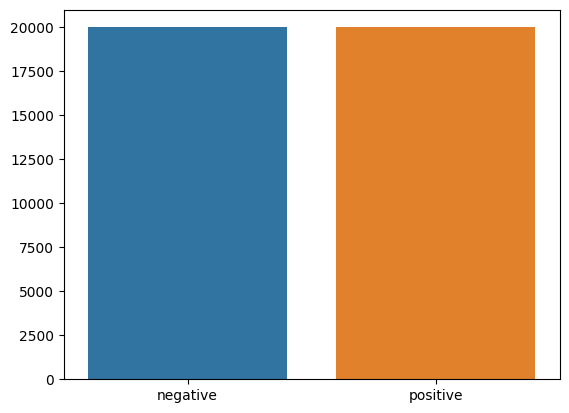

In [ ]:
# plotting sentiment distribution
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

# Text preprocessing

* Text preprocessing and tokenization is a critical first step. First, we clean up the text data by removing punctuation, extra spaces, and numbers.

* We then transform sentences into individual words, remove common words (known as "stop words"), and keep track of the 1000 most frequently used words in the dataset. These words are then assigned a unique identifier, forming a dictionary for one-hot encoding.

* The code essentially is converting the original text sentences into sequences of these unique identifiers, translating human language into a format that a machine learning model can understand.

In [ ]:
# download stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s


def tokenize(x_train,y_train,x_val,y_val):
    word_list = []


    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split()
                                    if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = [1 if label =='positive' else 0 for label in y_train]
    encoded_test = [1 if label =='positive' else 0 for label in y_val]
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


x_train,y_train,x_test,y_test,vocab = tokenize(x_train,y_train,x_test,y_test)

<ipython-input-47-e77f6296e34a>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict


Let’s analyze the token length in x_train.

<Axes: >

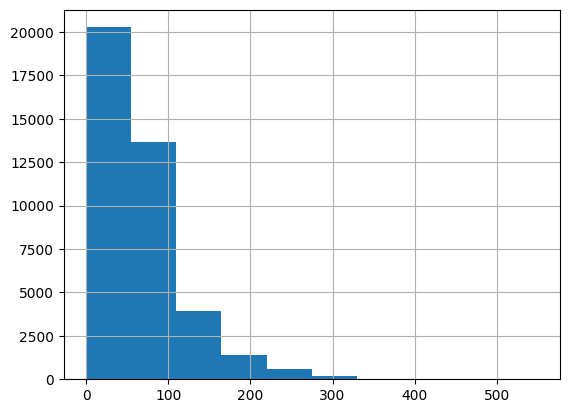

In [ ]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()

## Preparing the data for the model


Given the variable token lengths of each review, it's necessary to standardize them for consistency. As the majority of reviews contain less than 500 tokens, we'll establish 500 as the fixed length for all reviews.


In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features


x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

Next, we use DataLoader class to create the final dataset for model training.

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))


# dataloaders
batch_size = 50


# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)


# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)


print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample output: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  41,   2,  44],
        [  0,   0,   0,  ..., 537, 520, 225],
        [  0,   0,   0,  ..., 580,  29, 126],
        ...,
        [  0,   0,   0,  ...,  66, 127,  45],
        [  0,   0,   0,  ..., 185,  89, 151],
        [  0,   0,   0,  ...,  19,  16, 307]])
Sample output: 
 tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1])


## Define the LSTM model

* The SentimentRNN class is a PyTorch model that starts with an embedding layer, which transforms word indices into a dense representation that captures the semantic meaning of words. This is followed by an LSTM layer that processes the sequence of word embeddings.

* The LSTM's hidden state is passed through a dropout layer (for regularizing the model and preventing overfitting) and a fully connected layer, which maps the LSTM outputs to the final prediction. The prediction is then passed through a sigmoid activation function, converting raw output values into probabilities. The forward method defines the forward pass of data through this network, and the init_hidden method initializes the hidden states of the LSTM layer to zeros.

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)


        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

### Now we will initialize the SentimentRNN class that we defined above with the required parameters.

In [ ]:
no_layers = 2 # Number of layers in the RNN model
vocab_size = len(vocab) + 1 #extra 1 for padding , Total vocabulary size, adding 1 for padding token
embedding_dim = 64  # Dimension of word embeddings
output_dim = 1   # Dimension of the output (binary sentiment prediction)
hidden_dim = 256  # Dimension of the hidden state of the RNN

# Create an instance of the SentimentRNN model with the specified parameters
model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions


lr=0.001    # define learning rate

criterion = nn.BCELoss()

# Define the optimizer for model parameters using the Adam optimizer and the specified learning rate (lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

## Start training

In [ ]:
clip = 5  # to avoid exploding gradients during training
epochs = 5
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]


for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        model.zero_grad()
        output,h = model(inputs,h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])


            inputs, labels = inputs.to(device), labels.to(device)


            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())


            val_losses.append(val_loss.item())

            accuracy = acc(output,labels)
            val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.5330340052768588 val_loss : 0.4337237295508385
train_accuracy : 73.485 val_accuracy : 80.13
Validation loss decreased (inf --> 0.433724).  Saving model ...
Epoch 2
train_loss : 0.40127632606774566 val_loss : 0.3718911650031805
train_accuracy : 82.5875 val_accuracy : 83.65
Validation loss decreased (0.433724 --> 0.371891).  Saving model ...
Epoch 3
train_loss : 0.34596070426516234 val_loss : 0.34700686518102886
train_accuracy : 85.41499999999999 val_accuracy : 85.32
Validation loss decreased (0.371891 --> 0.347007).  Saving model ...
Epoch 4
train_loss : 0.30957734063267706 val_loss : 0.33422094441950323
train_accuracy : 87.095 val_accuracy : 85.69
Validation loss decreased (0.347007 --> 0.334221).  Saving model ...
Epoch 5
train_loss : 0.28331602601334455 val_loss : 0.3470190513134003
train_accuracy : 88.32 val_accuracy : 85.72999999999999


### Model evaluation

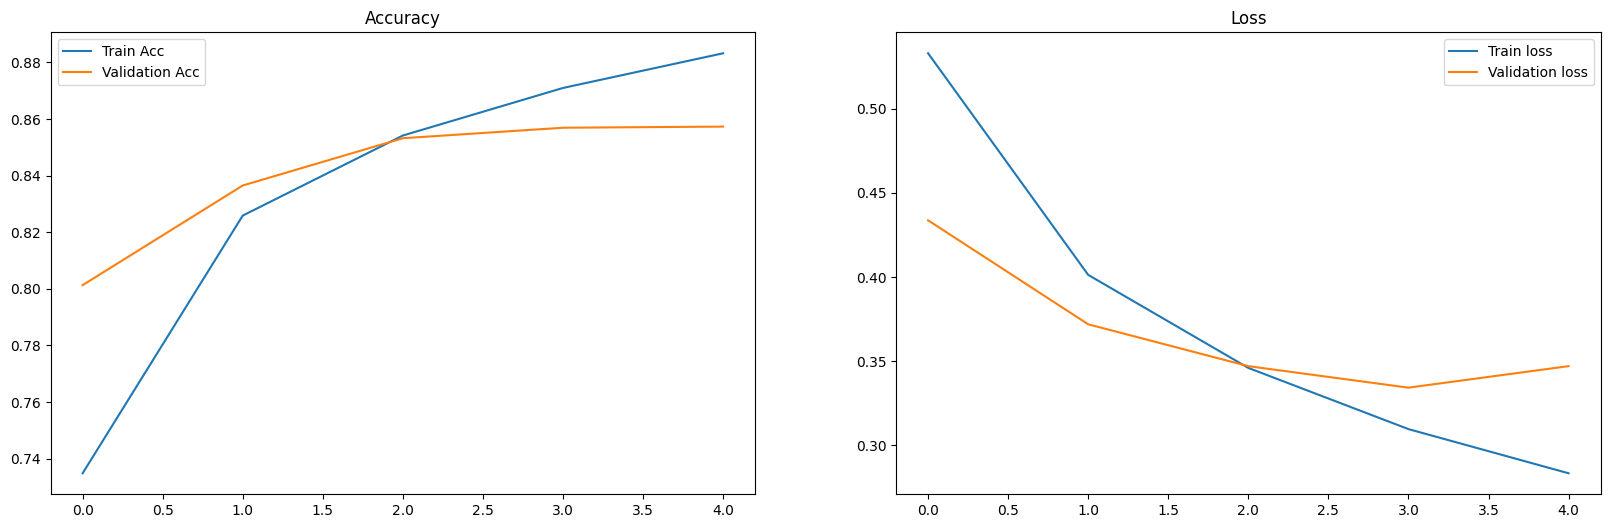

In [ ]:
# plotting model accuracy and loss

fig = plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()

plt.show()

## Inference / Prediction

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())


index = 30
print(data['review'][index])
print('='*70)
print(f'Actual sentiment is  : {data["sentiment"][index]}')
print('='*70)
pro = predict_text(data['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Set the model to evaluation mode
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        val_h = model.init_hidden(batch_size)
        val_h = tuple([each.data for each in val_h])
        inputs, labels = inputs.to(device), labels.to(device)
        output, val_h = model(inputs, val_h)
        predictions = torch.round(output)
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert the lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=['negative', 'positive'])

print(report)

              precision    recall  f1-score   support

    negative       0.87      0.84      0.85      5000
    positive       0.84      0.88      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

